# SPARQL queries analysis

In this notebook we analyse SPARQl queries.

In [10]:
import json
import re
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

color_palette = ['#5565cf', '#b14ecf', '#cf4773', '#cf913f', '#87cf38', '#30cf6b', '#29a1cf', '#2138cf']

file_path = 'data_stories_summary.json'
with open(file_path, 'r') as file:
    data = json.load(file)

In [4]:
data_sources_list = []

service_pattern = re.compile(r'SERVICE\s*<([^>]+)>', re.IGNORECASE)

for story_id, story_data in data.items():
    data_sources_list.append(story_data["sparql_endpoint"].split("//")[1])
    queries = story_data.get('queries', [])

    for query_dict in queries:
        query = re.sub(r'\s+', ' ', query_dict['query']).strip()
        service_matches = service_pattern.findall(query)
        for service_url in service_matches:
            if service_url:
                data_sources_list.append(service_url.split("//")[1])


data_sources_counts = Counter(data_sources_list)
data_sources_df = pd.DataFrame(data_sources_counts.items(), columns=["Source Type", "Count"])

print("\nSource Type Usage Frequency:")
print(data_sources_df)


Source Type Usage Frequency:
                                         Source Type  Count
0                          query.wikidata.org/sparql     42
1             polifonia.disi.unibo.it/musicbo/sparql      6
2    query.wikidata.org/bigdata/namespace/wdq/sparql     23
3                                 dbpedia.org/sparql      4
4                         dati.cultura.gov.it/sparql      1
5  triplestore.netwerkdigitaalerfgoed.nl/reposito...      1


In [ ]:
# Federated queries
    
# Regular expression to capture all federated endpoints in SERVICE clauses
service_pattern = re.compile(r'SERVICE\s*<([^>]+)>', re.IGNORECASE)

total_queries = 0
federated_queries = 0
federated_endpoints = []

for story_id, story_data in data.items():
    queries = story_data.get('queries', [])
    main_endpoint = story_data.get("sparql_endpoint", "")
    if main_endpoint:
        data_sources_list.append(main_endpoint.split("//")[1])  # Keep everything after the //

    for query_dict in queries:
        total_queries += 1  # Increment total query count
        query = query_dict.get('query', '')
        
        # Find all SERVICE matches (for federated queries)
        service_matches = service_pattern.findall(query)
        
        # If SERVICE matches are found, this is a federated query
        if service_matches:
            federated_queries += 1  # Increment federated query count
            federated_endpoints.extend([service_url.split("//")[1] for service_url in service_matches])  # Keep the part after //

# Calculate percentage of federated queries
if total_queries > 0:
    percentage_federated = (federated_queries / total_queries) * 100
else:
    percentage_federated = 0

# Print the summary
print(f"Total Queries: {total_queries}")
print(f"Federated Queries: {federated_queries}")
print(f"Percentage of Queries using Federated Endpoints: {percentage_federated:.2f}%")

# Analyze federated endpoint usage
federated_endpoints_counter = Counter(federated_endpoints)
federated_endpoints_df = pd.DataFrame(federated_endpoints_counter.items(), columns=["Federated Endpoint", "Count"])

print("\nFederated Endpoint Usage Frequency:")
print(federated_endpoints_df)

Total Queries: 464
Federated Queries: 26
Percentage of Queries using Federated Endpoints: 5.60%

Federated Endpoint Usage Frequency:
                                Federated Endpoint  Count
0  query.wikidata.org/bigdata/namespace/wdq/sparql     23
1                               dbpedia.org/sparql      2
2                       dati.cultura.gov.it/sparql      1


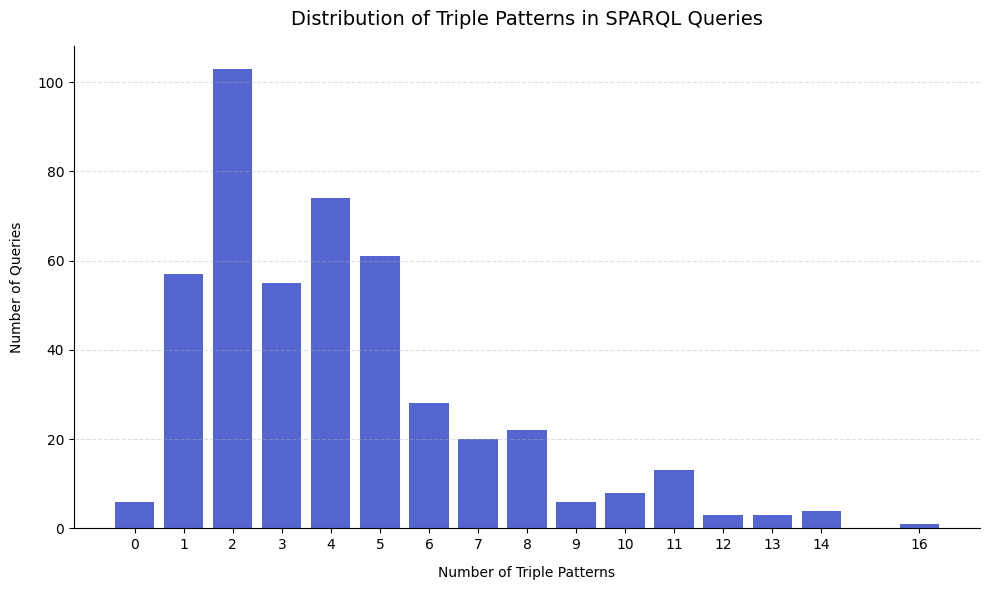

In [ ]:
def extract_where_clause(query):
    start = query.find('WHERE')
    if start == -1:
        return None

    # Find the opening brace
    start = query.find('{', start)
    if start == -1:
        return None

    # Use a stack to find the matching closing brace
    stack = []
    for i in range(start, len(query)):
        if query[i] == '{':
            stack.append('{')
        elif query[i] == '}':
            stack.pop()
            if not stack:
                return query[start + 1:i]  # Return the content between the outermost braces

    return None  # In case the braces are unbalanced

def count_triple_patterns(query):
    where_clause = extract_where_clause(query)
    
    if where_clause:
        # Normalize the where_clause by removing unnecessary newlines and spaces
        where_clause = where_clause.replace('\r', '').replace('\n', ' ').strip()

        # Split triples by the main delimiters
        triple_groups = re.split(r'\.\s*', where_clause)
        triple_count = 0

        for group in triple_groups:
            group = group.strip()
            if not group:
                continue
            if 'OPTIONAL' in group or 'SERVICE' in group or 'FILTER' in group:
                # Skip counting these as they don't always represent triples
                if 'OPTIONAL' in group or 'SERVICE' in group:
                    inner_triples = re.findall(r'\{(.*?)\}', group, re.DOTALL)
                    for triple_block in inner_triples:
                        triple_count += count_triple_patterns(triple_block)
            else:
                # Count triples by semicolon and comma structure
                subject_predicate_pairs = group.split(';')
                for pair in subject_predicate_pairs:
                    objects = pair.split(',')
                    # Only count as a triple if it has a valid subject-predicate-object structure
                    if len(objects) > 0:
                        triple_count += len(objects)               
        return triple_count
    else:
        return 0

queries = []

for story_id, story_data in data.items():
    story_queries = story_data.get('queries', [])
    
    for query_dict in story_queries:
        query = query_dict.get('query', '')
        if query:
            query = re.sub(r'(^|\s)#.*?(\r\n|\n)', r'\1', query)
            query = re.sub(r'\s+', ' ', query).strip()
            queries.append(query)

triple_counts = [count_triple_patterns(query) for query in queries]
triple_pattern_counter = Counter(triple_counts)

num_triple_patterns = list(triple_pattern_counter.keys())
num_queries = list(triple_pattern_counter.values())

plt.figure(figsize=(10, 6))
plt.bar(num_triple_patterns, num_queries, color=color_palette[0])
plt.title('Distribution of Triple Patterns in SPARQL Queries',  fontsize=14, pad=15)
plt.xlabel('Number of Triple Patterns', labelpad=10)
plt.ylabel('Number of Queries', labelpad=10)
plt.xticks(ticks=num_triple_patterns)
plt.grid(axis='y', linestyle='--', alpha=0.4)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
# Save as JPG with 300 dpi
# plt.savefig("outputs/img/10.jpg", dpi=300, bbox_inches="tight", format="jpg")

# Save as EPS (vector format, resolution-independent)
# plt.savefig("outputs/img/10.eps", format="eps", bbox_inches="tight")

plt.show()


In [ ]:
def classify_element(element):
    element = element.strip()
    if element.startswith('?') or element.startswith('$'):
        return 'V'  # Variable
    elif element.startswith('<') and element.endswith('>'):
        return 'C'  # Constant URI
    elif ':' in element and not (element.startswith('"') or element.endswith('"')):
        return 'C'  # Prefixed name
    elif element.startswith('"') and element.endswith('"'):
        return 'C'  # Literal
    else:
        return 'C'

# Function to split the WHERE clause by periods, but only outside of curly braces
def split_outside_braces(where_clause):
    result = []
    buffer = []
    brace_depth = 0

    for char in where_clause:
        if char == '{':
            brace_depth += 1
        elif char == '}':
            brace_depth -= 1
        
        if char == '.' and brace_depth == 0:
            # We're at a period and not inside braces, so we split here
            result.append(''.join(buffer).strip())
            buffer = []
        else:
            # Keep building the current part of the clause
            buffer.append(char)
    
    # Append any remaining part after the last period
    if buffer:
        result.append(''.join(buffer).strip())
    
    return result

# Function to classify and extract triple patterns (updated to use the new splitting method)
def classify_triple_patterns(where_clause):
    # where_clause = extract_where_clause(query)  # Use the provided extract_where_clause function
    patterns = []

    if where_clause:
        # Split WHERE clause into triple groups using the custom function
        triple_groups = split_outside_braces(where_clause)
        
        for group in triple_groups:
            group = group.strip()
            if not group:
                continue
            if 'OPTIONAL' in group or 'SERVICE' in group:
                # Handle OPTIONAL and SERVICE clauses
                inner_triples = re.findall(r'\{(.*?)\}', group, re.DOTALL)
                for triple_block in inner_triples:
                    patterns.extend(classify_triple_patterns(triple_block))  # Recursively classify nested triples
            else:
                # Regex to capture subject-predicate-object triples
                triples = re.findall(
                    r'(\?[^\s]+|<[^>]+>|\"[^\"]+\"|[^\s]+:[^\s]+)\s+(\?[^\s]+|<[^>]+>|\"[^\"]+\"|[^\s]+:[^\s]+)\s+(\?[^\s]+|<[^>]+>|\"[^\"]+\"|[^\s]+:[^\s]+)',
                    group
                )
                for triple in triples:
                    subject, predicate, obj = triple
                    pattern = f"{classify_element(subject)}{classify_element(predicate)}{classify_element(obj)}"
                    patterns.append(pattern)

    return patterns

# Process all queries in the data
patterns_counter = Counter()
for query in queries:
    where_clause = extract_where_clause(query)  # Call extract_where_clause only once here
    if where_clause:

        patterns = classify_triple_patterns(where_clause)
        patterns_counter.update(patterns)

# Calculate the percentage for each pattern
total_triples = sum(patterns_counter.values())
pattern_percentages = {pattern: (count / total_triples) * 100 for pattern, count in patterns_counter.items()}

df = pd.DataFrame.from_dict(pattern_percentages, orient='index', columns=['Percentage'])
df.index.name = 'Pattern'
df = df.reset_index()
df['Percentage'] = df['Percentage'].apply(lambda x: f"{x:.2f}%")

print(df)

  Pattern Percentage
0     VVC      8.12%
1     VCC     23.37%
2     VCV     40.28%
3     CCC     15.81%
4     CCV     10.09%
5     CVC      1.48%
6     VVV      0.43%
7     CVV      0.43%


{'FILTER': 178, 'OPTIONAL': 110, 'BIND': 16, 'UNION': 42, 'MINUS': 1, 'COUNT': 203, 'DISTINCT': 353, 'LIMIT': 178, 'OFFSET': 9, 'ORDER BY': 159, 'GROUP BY': 127, 'SUM': 8, 'SAMPLE': 1, 'GROUP_CONCAT': 1, 'VALUES': 3, 'STR': 33, 'LANG': 96, 'IF': 1, 'CONTAINS': 4, 'REPLACE': 3, 'ROUND': 1, 'ASC': 11, 'DESC': 79}


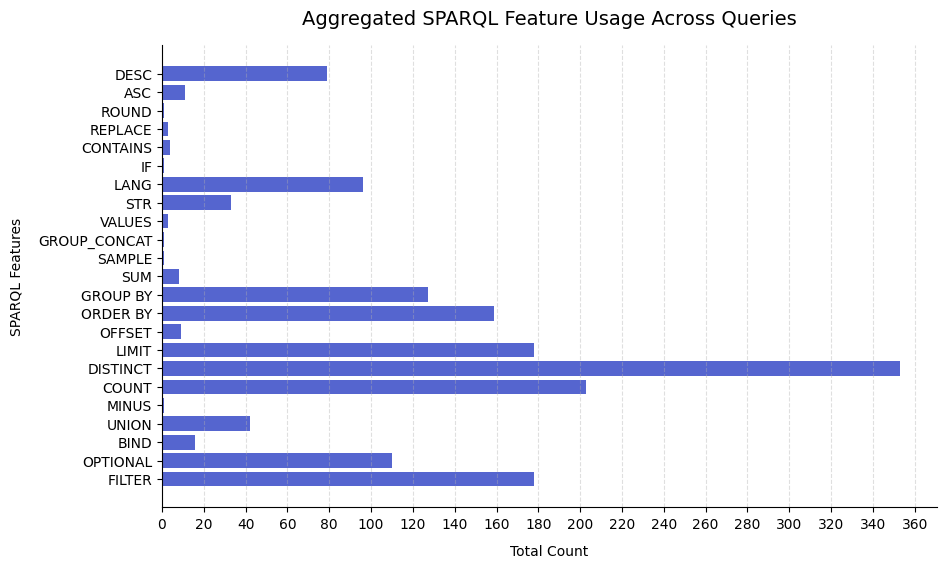

In [ ]:
# List of SPARQL features to look for
sparql_features = ["FILTER", "OPTIONAL", "BIND", "UNION", "MINUS", "COUNT", 
                   "DISTINCT", "LIMIT", "OFFSET", "ORDER BY", "GROUP BY", "SUM", "SAMPLE", 
                   "GROUP_CONCAT", "VALUES", "STR", "LANG", "IF", "CONTAINS", "REPLACE", "ROUND", "ASC", "DESC"]


def clean_query_text(query):
    # Remove comments
    query = re.sub(r'(^|\s)#.*?(\r\n|\n)', r'\1', query)
    # Normalize whitespace
    query = re.sub(r'\s+', ' ', query)
    # Remove variables like ?varName
    query = re.sub(r'\?[^\s\)\(]*', '', query)
    # Remove URIs like <http://example.org/prop>
    query = re.sub(r'<[^>]*>', '', query)
    return query.strip()

# Function to count features in a query
def count_sparql_features(query, features):
    query = clean_query_text(query)
    feature_counts = {
        feature: len(re.findall(r'\b' + re.escape(feature) + r'\b', query, re.IGNORECASE))
        for feature in features
    }
    return feature_counts

# Dictionary to accumulate feature counts across all queries
total_feature_counts = {feature: 0 for feature in sparql_features}

# To store detailed counts per story (optional, for further analysis)
story_feature_counts = {}

# Loop through each story and its queries
for story_id, story_data in data.items():
    story_queries = story_data.get('queries', [])
    story_counts = {feature: 0 for feature in sparql_features}
    
    for query_dict in story_queries:
        query = query_dict.get('query', '')
        if query:
            feature_counts = count_sparql_features(query, sparql_features)
            for feature, count in feature_counts.items():
                total_feature_counts[feature] += count
                story_counts[feature] += count
    
    # Save per-story counts
    story_feature_counts[story_id] = story_counts

print(total_feature_counts)


plt.figure(figsize=(10, 6))
plt.barh(list(total_feature_counts.keys()), list(total_feature_counts.values()), color=color_palette[0])
plt.title('Aggregated SPARQL Feature Usage Across Queries',  fontsize=14, pad=15)
plt.xlabel('Total Count', labelpad=10)
plt.ylabel('SPARQL Features', labelpad=10)
plt.grid(axis='x', linestyle='--', alpha=0.4)
max_val = max(total_feature_counts.values())
plt.xticks(np.arange(0, max_val + 20, 20))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Save as JPG with 300 dpi
# plt.savefig("outputs/img/11.jpg", dpi=300, bbox_inches="tight", format="jpg")

# Save as EPS (vector format, resolution-independent)
# plt.savefig("outputs/img/11.eps", format="eps", bbox_inches="tight")
plt.show()